<a href="https://colab.research.google.com/github/ASWINR341/pytorch_project/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Available device: ", device)

Available device:  cpu


In [ ]:
image_path = []
labels= []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns= ["image_path", 'labels'])
print(data_df["labels"].unique())
data_df.head()

['dog' 'cat' 'wild']


,image_path,labels
0,/content/animal-faces/afhq/train/dog/flickr_do...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [ ]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)


(11291, 2)
(2420, 2)
(2419, 2)


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])


In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]

    image = Image.open(img_path).convert("RGB")

    if self.transform:
      image = self.transform(image).to(device)

    return image, label


In [ ]:
train_dataset = CustomImageDataset(train, transform=transform)
val_dataset = CustomImageDataset(val, transform=transform)
test_dataset = CustomImageDataset(test, transform=transform)

In [ ]:
train_dataset.__getitem__(2)

(tensor([[[0.4549, 0.4157, 0.4000,  ..., 0.5725, 0.5412, 0.5294],
          [0.4353, 0.4235, 0.4196,  ..., 0.5569, 0.5412, 0.5176],
          [0.4196, 0.4314, 0.4275,  ..., 0.5725, 0.5686, 0.5412],
          ...,
          [0.5725, 0.5412, 0.5529,  ..., 0.6431, 0.6784, 0.6863],
          [0.5922, 0.5843, 0.5725,  ..., 0.6549, 0.5882, 0.6471],
          [0.5569, 0.5412, 0.5647,  ..., 0.6471, 0.5608, 0.5176]],
 
         [[0.4118, 0.3725, 0.3569,  ..., 0.5569, 0.5255, 0.5137],
          [0.3922, 0.3804, 0.3765,  ..., 0.5412, 0.5255, 0.5020],
          [0.3765, 0.3843, 0.3843,  ..., 0.5569, 0.5529, 0.5255],
          ...,
          [0.4667, 0.4353, 0.4471,  ..., 0.5490, 0.5843, 0.5922],
          [0.4863, 0.4784, 0.4667,  ..., 0.5608, 0.4941, 0.5529],
          [0.4510, 0.4353, 0.4588,  ..., 0.5529, 0.4667, 0.4196]],
 
         [[0.4000, 0.3569, 0.3412,  ..., 0.5451, 0.5137, 0.5020],
          [0.3843, 0.3725, 0.3686,  ..., 0.5294, 0.5137, 0.4902],
          [0.3765, 0.3882, 0.3843,  ...,

In [ ]:
label_encoder.inverse_transform([0])

array(['cat'], dtype=object)

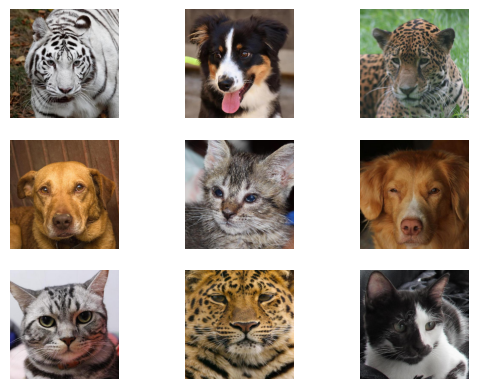

In [ ]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row, col].imshow(image)
    axarr[row, col].axis("off")

plt.show()

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding =1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2, 2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(128*16*16, 128)

    self.output = nn.Linear(128, len(data_df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x) #->(32,128,128)
    x = self.pooling(x) #->(32,64,64)
    x = self.relu(x)

    x = self.conv2(x) #->(64,64,64)
    x = self.pooling(x) #->(64,32,32)
    x = self.relu(x)

    x = self.conv3(x) #->(128,32,32)
    x = self.pooling(x) #->(128,16,16)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.relu(x)

    x = self.output(x)

    return x

In [ ]:
model = Net().to(device)

In [ ]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 3]             387
Total params: 4,288,067
Trainable param

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [40]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_validation = 0
  total_loss_validation = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)

    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis =1) == labels).sum().item()

    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad(): #va++++++++lidation process
    for inputs, labels in val_loader:
      outputs = model(inputs)

      val_loss = criterion(outputs, labels)
      total_loss_validation += val_loss.item()

      val_acc = (torch.argmax(outputs, axis =1) == labels).sum().item()
      total_acc_validation += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_validation/1000,4))

  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__()) * 100,4))
  total_acc_validation_plot.append(round((total_acc_validation/val_dataset.__len__()) * 100,4))

  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000,4)} Train Accuracy {round((total_acc_train/train_dataset.__len__()) * 100,4)}
        Validation Loss: {round(total_loss_validation/1000,4)} Validation Accuracy {round((total_acc_validation/val_dataset.__len__()) * 100,4)}
  ''')



Epoch 1/10, Train Loss: 0.4087 Train Accuracy 74.8826
        Validation Loss: 0.0463 Validation Accuracy 89.0083
  
Epoch 2/10, Train Loss: 0.1842 Train Accuracy 90.4791
        Validation Loss: 0.0322 Validation Accuracy 92.1488
  
Epoch 3/10, Train Loss: 0.1333 Train Accuracy 93.145
        Validation Loss: 0.0247 Validation Accuracy 94.0083
  
Epoch 4/10, Train Loss: 0.102 Train Accuracy 94.9252
        Validation Loss: 0.0232 Validation Accuracy 94.5868
  
Epoch 5/10, Train Loss: 0.0812 Train Accuracy 95.8374
        Validation Loss: 0.0188 Validation Accuracy 95.5785
  
Epoch 6/10, Train Loss: 0.065 Train Accuracy 96.7319
        Validation Loss: 0.022 Validation Accuracy 94.3388
  
Epoch 7/10, Train Loss: 0.0523 Train Accuracy 97.6264
        Validation Loss: 0.0265 Validation Accuracy 93.2231
  
Epoch 8/10, Train Loss: 0.0432 Train Accuracy 97.8478
        Validation Loss: 0.0169 Validation Accuracy 95.7438
  
Epoch 9/10, Train Loss: 0.0373 Train Accuracy 98.1844
        Valida

In [47]:
with torch.no_grad():
  total_acc_test = 0
  total_loss_test = 0

  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis =1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)

    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100,4)} and Loss is: {round(total_loss_test/1000,4)} ")



Accuracy Score is: 95.9487 and Loss is: 0.0195 


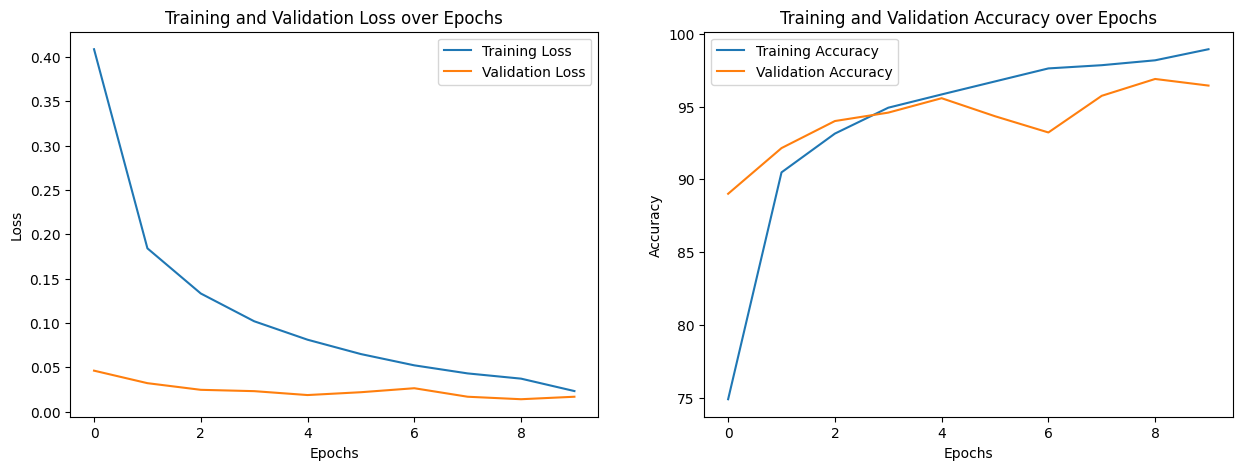

In [48]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_validation_plot, label = "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


In [68]:
# 1 -read Image
# 2- Transform using image object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    print(image.shape)
    output = model(image.unsqueeze(0))
    output = torch.argmax(output, axis=1)

    return label_encoder.inverse_transform(output.cpu())[0]

In [69]:
predict_image("/content/download (2).jpg")

torch.Size([3, 128, 128])


'dog'